In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish
from gym_fish.envs.lib import pyflare as fl

In [3]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


In [4]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'
fluid_json = json_folder+'fluid_param_test.json'
rigid_json = json_folder+'rigids_flatfish.json'
print(Path("./py_data/jsons/paths/path_ss.json").exists())


True


In [5]:
gpuId = 0

control_dt=0.2
theta = np.array([0,0])
vel_theta = np.array([0,0])
random_vel = np.array([0,0.0])
radius=1.0
max_time = 10
action_max= 10
done_dist = 0.15
dist_distri_param =np.array([0,0.0])
couple_mode =  fl.COUPLE_MODE.TWO_WAY

ratio = 0.005/control_dt*(max_time/10)
use_com=False

wr = 0.0*np.array([1.0,0.5])
wp = 1.0*np.array([0.0,1.0])
wa = 0.5
live_penality =-0.05

In [6]:
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,control_dt=control_dt,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
                   )

In [7]:
env.save_data()

In [8]:
env.action_dim

5

In [9]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


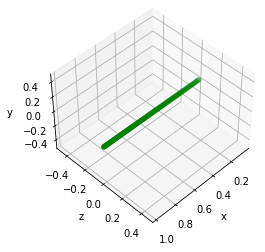

In [10]:
path_points =np.array( [
    env.init_pos*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)

])
trajectory_points = env.trajectory_points
ax=plt.figure().add_subplot(111, projection = '3d')
X = path_points[:,0]
Y = path_points[:,1]
Z = path_points[:,2]
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
ax.scatter3D(xs=X, zs=Y, ys=Z,c='g')
if trajectory_points!=None:
    ax.scatter3D(xs=[x[0] for x in trajectory_points],
        zs=[x[1] for x in trajectory_points],
        ys=[x[2] for x in trajectory_points],
        c=[[0,0,i/len(trajectory_points)] for i in range(len(trajectory_points))])
ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
# ax.scatter(env.path_start[0],env.path_start[2],env.path_start[1])
# ax.scatter(env.goal_pos[0],env.goal_pos[2],env.goal_pos[1])
# ax.scatter(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1])
# ax.scatter(env.proj_pt_world[0],env.proj_pt_world[2],env.proj_pt_world[1])
plt.show()

In [11]:
from gym_fish.envs.py_util import flare_util
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory

fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')

True

In [12]:
env.dataPath['trajectory']

'/root/pytorch_fish/data/vis_data/Trajectory'

In [13]:
# env.stepOnce([0])
print(env.rigid_data.rigidWorld.getTimestep())
# env_test.save_data( save_fluid=True, save_objects=True,frame_num=0)
# check path, check object head and position ,data saving 
pd_controller = fl.PDControl1D(0.5,0.01,env.rigid_data.rigidWorld.time)

# env.plot3d()

0.004000000189989805


In [14]:
def getPIDResponse():
    skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
#     pos = skeleton_dynamics.getBaseLink().getPosition()
#     env.curPose_t = env.path_data.trajectory.getReferencePose(pos)
#     target_pos = env.path_data.trajectory.getPose(env.curPose_t+0.05).getPosition()
#     fwd = skeleton_dynamics.getBaseLinkFwd()
#     fwd = fwd/np.linalg.norm(fwd)
#     right = skeleton_dynamics.getBaseLinkRight()
#     right = right/np.linalg.norm(right)
#     expected_fwd = target_pos - pos
#     expected_fwd = expected_fwd/np.linalg.norm( expected_fwd)
    
#     angleShift = math.acos(fwd.dot(expected_fwd))
#     if (expected_fwd - fwd).dot(-right)<=0:
#         angleShift = -angleShift
#     offset = pd_controller.feedback(angleShift, env.rigid_data.rigidWorld.time)
    offset = 0
    targetAngle = (3.1415/6)*math.sin(6.28*2*env.rigid_data.rigidWorld.time)+offset;
#     print((targetAngle-skeleton_dynamics.getJoint("spine02").getPositions()[0])/env.rigid_data.rigidWorld.getTimestep())
    return (targetAngle-skeleton_dynamics.getJoint("spine02").getPositions()[0])/env.rigid_data.rigidWorld.getTimestep()
#     return targetAngle/env.action_space_std

In [15]:
def plot_infos(infos,title=None,reward_fig_name=None):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    if(title):
        plt.title(title)
    if(reward_fig_name):
        plt.savefig(reward_fig_name)
    plt.show()

In [16]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [17]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴

    dp_local = np.dot(env.world_to_local,np.transpose(env.goal_pos-env.body_xyz))
    dxyz = dp_local
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",)
    if env.trajectory_points!=None:
        ax.scatter3D(xs=[x[0] for x in env.trajectory_points],
            zs=[x[1] for x in env.trajectory_points],
            ys=[x[2] for x in env.trajectory_points],
            c=[[0,0,i/len(env.trajectory_points)] for i in range(len(env.trajectory_points))])
    fig.canvas.draw()
#     plt.show()
#     plt.pause(0.0001)

In [18]:
%matplotlib notebook

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


<IPython.core.display.Javascript object>


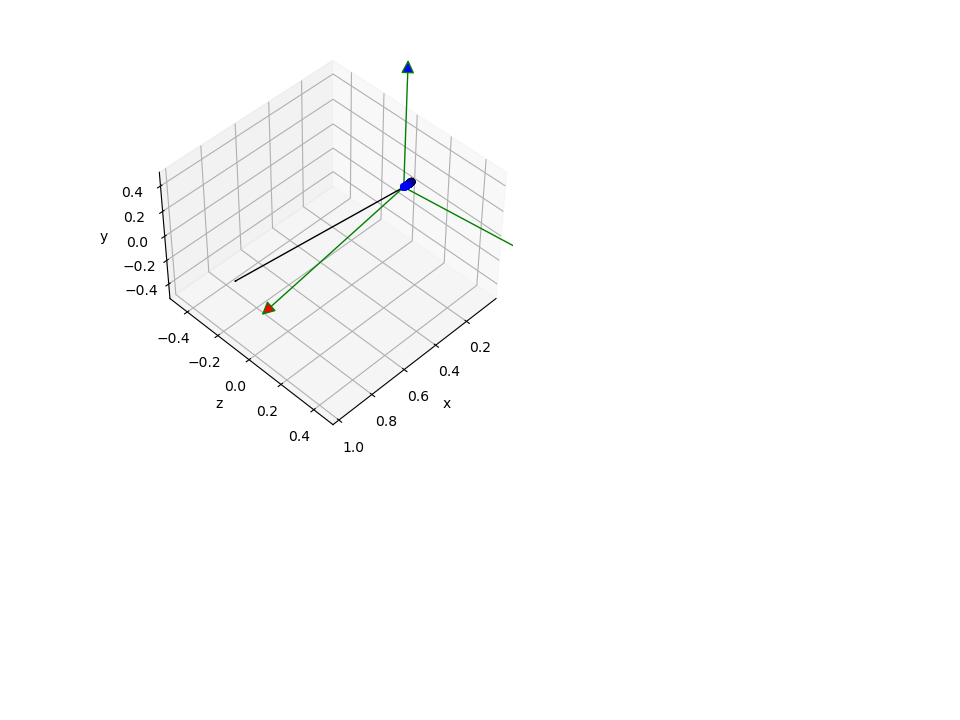

KeyboardInterrupt: 

In [20]:
!./clean_visdata.sh
import random
for i in range(1):
    env.reset()
    # env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
    # env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0.)
    # joint_list =['spine','spine01','spine02','spine03']
    # for jnt_name in joint_list:
    #     env.rigid_data.skeletons[0].dynamics.getJoint(jnt_name).setPosition(0,0)
    #     env.rigid_data.skeletons[0].dynamics.getJoint(jnt_name).setVelocity(0,0)
    # env.rigid_data.skeletons[0].dynamics.update()
    # env.set_task(0,0.01)
    start_time = time.time()
    env.training=False
    done = False
    infos = []

    vels = []
    linear_accels = []
    angular_accels = []
    joint_accels=[]
    actions = []
    rewards = []
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.ion()
    # act=0.5
    while not done :
#         act = (getPIDResponse()+(0)/env.rigid_data.rigidWorld.getTimestep())/13
        act = math.sin(6.28*2*env.rigid_data.rigidWorld.time)
#         act = act+0.5
#         act = 0
    
#         act = act*(env.rigid_data.rigidWorld.time<1)
    #     if act<0:
    #         act=act*4;
    #     act = 1
    #     act = ((3.1415/6)*math.sin(6.28*2*env.rigid_data.rigidWorld.time)+0.52)/env.rigid_data.rigidWorld.getTimestep()/13
    #     act = act*(env.rigid_data.rigidWorld.time<1)
        aaa =  np.ones(int(env.action_dim))*act
#         aaa = np.concatenate((np.ones(int(env.action_dim/2))*act,-np.ones(int(env.action_dim/2))*act))
        obs,r,done,info=env.step(aaa,save_fluid=False, save_objects=False)
        rewards.append(r)
    #     vels.append(env.rigid_data.skeletons[0].dynamics.getBaseLink().getLinearVelocity())
    #     linear_accels.append(env.rigid_data.skeletons[0].dynamics.getBaseLink().getLinearAcceleration())
    #     angular_accels.append(env.rigid_data.skeletons[0].dynamics.getBaseLink().getAngularAcceleration())
    #     joint_accels.append(env.rigid_data.skeletons[0].dynamics.getJoint("head").getAccelerations())
        plot_env(env,ax)
        infos.append(info)
#     plt.close(fig)
    env.plot3d()
    # plot_infos(infos)
    end_time = time.time()
    print(end_time-start_time,env.rigid_data.rigidWorld.time)